Neste notebook:
* Avaliação de usuários por bucket  
    * em média, e mediana, em quantos buckets os utilizadores estão.  
    * quantos usuários novos estão em cada bucket e quantos não ocorrem

Objetivo:
* explorar caracteristicas dos datasets que permitam
    * avaliar se o dataset é util para a análise  
    * escolher o número de buckets  

Vamos definir o numero de itens em cada bucket como 50k

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData
from recommenders_implicit import ISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout
from dataset_evaluation_utils import * #get_interactions_info, plot_interactions_per_month, plot_user_presence_distribution, plot_n_users_per_bucket, plot_bucket_size

from datetime import datetime, timedelta

import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
# Movielens

In [3]:
# importa dataset 'movielensm1'
data = pd.read_csv("../datasets/ml1m_gte5.csv","\t")
# Necessary Preprocess - create date from timestamp
data['date'] = data['Timestamp'].apply(lambda x: datetime.fromtimestamp( x ).date() )
data['year'] = data['Timestamp'].apply(lambda x: datetime.fromtimestamp( x ).year)
data['month'] = data['Timestamp'].apply(lambda x: datetime.fromtimestamp( x ).month )
data['date'] = data[['year', 'month']].apply(lambda x: datetime.strptime( str(x[0])+'/'+str(x[1]), '%Y/%m' ) , axis=1)

In [4]:
# this lets me sample the first 10% of the dataset to avoid cold start.
# data.iloc[ :int( 0.1*data.shape[0] ) ]

## Evaluating Time defined Buckets 

How many interactions occur in each month?

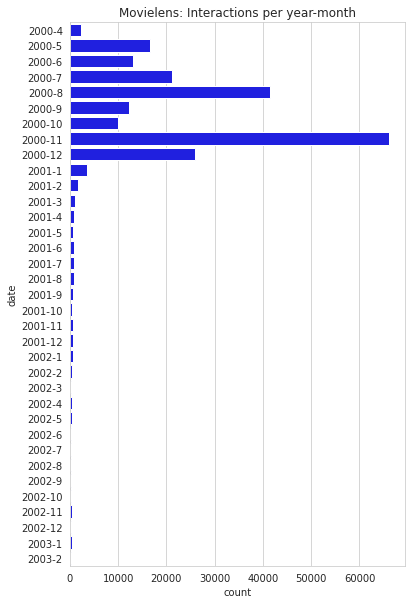

In [5]:
plot_interactions_per_month(data=data, dataset_name='Movielens')

What is the user presence distribution based on month, quarter, and semester?

In [6]:
user_presence_df, user_month_interactions, trimestres, user_trimestre_interactions, semestres, user_semestre_interactions = get_interactions_info(data=data, user_col='UserID')

In [7]:
user_presence_df.head()

,UserID,month_%,trimestre_%,semestre_%
0,195,0.742857,0.833333,0.833333
1,1088,0.685714,0.833333,0.833333
2,1733,0.628571,0.833333,0.833333
3,343,0.600000,0.833333,0.833333
4,424,0.571429,0.833333,0.833333


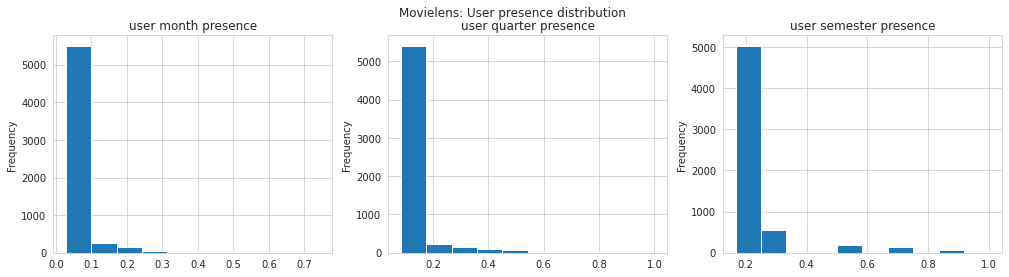

In [8]:
# plotting user frequency distribution
plot_user_presence_distribution(user_presence_df, dataset_name='Movielens')

How many examples are there per quarter and semester?

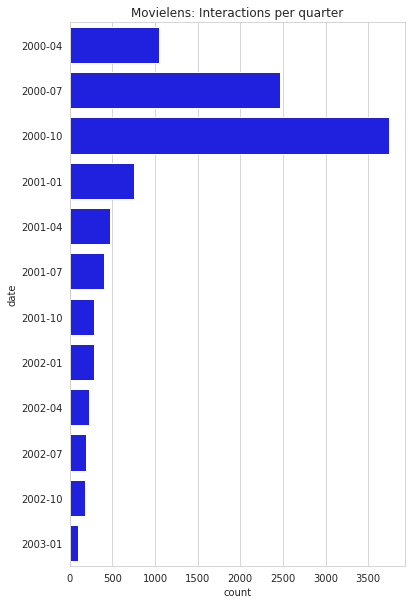

In [9]:
plot_interactions_per_qns(user_interactions=user_trimestre_interactions, date_range=trimestres, dataset_name='Movielens', type_of_range='quarter')

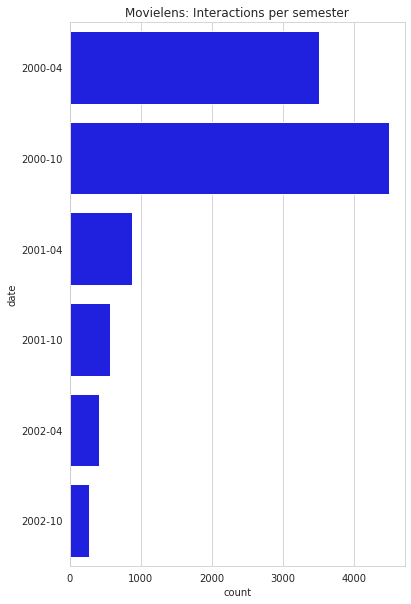

In [10]:
plot_interactions_per_qns(user_interactions=user_semestre_interactions, date_range=semestres, dataset_name='Movielens', type_of_range='semester')

How many FREQUENT users (occur in 80% or more intervals) exist?

In [11]:
# defining threshold
frequency_threshold = 0.8

In [12]:
frequent_users_month, frequent_users_trimestre, frequent_users_semestre = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)

0 users of 6014 (0.0%) occurr in 80.0% or more months.
9 users of 6014 (0.15%) occurr in 80.0% or more quarters.
93 users of 6014 (1.546%) occurr in 80.0% or more semesters.


In median terms, how many times FREQUENT users appear in each quarter, and semester?

In [13]:
freq_user_quarter_info = get_frequent_user_statistics(
    interactions_df=user_trimestre_interactions, frequent_users_list=frequent_users_trimestre)
# freq_user_quarter_info

<AxesSubplot:>

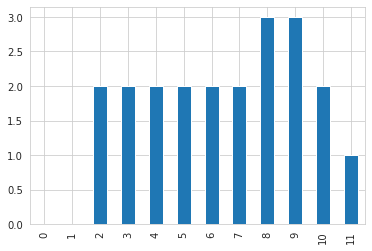

In [14]:
freq_user_quarter_info['median_freq_user_interactions'].plot(kind='bar')

<AxesSubplot:>

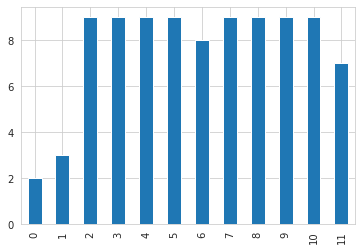

In [15]:
freq_user_quarter_info['freq_users_at_least_1_interaction'].plot(kind='bar')

In [16]:
# # frequent user interaction per quarter
# plot_interactions_per_qns(user_interactions=user_trimestre_interactions.loc[frequent_users_trimestre],
#     date_range=trimestres)

In [17]:
freq_user_semester_info = get_frequent_user_statistics(
    interactions_df=user_semestre_interactions, frequent_users_list=frequent_users_semestre)
# freq_user_semester_info

<AxesSubplot:>

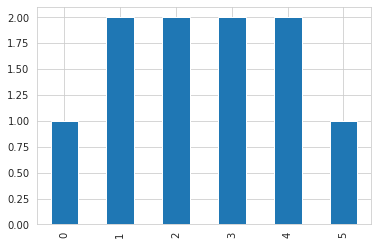

In [18]:
freq_user_semester_info['median_freq_user_interactions'].plot(kind='bar')

<AxesSubplot:>

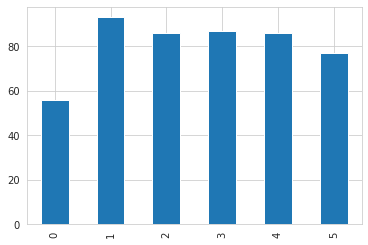

In [19]:
freq_user_semester_info['freq_users_at_least_1_interaction'].plot(kind='bar')

In [20]:
# these are the users that should be used in holdouts, and only their last interactions
# BUT, there are users that do not appear in some intervals, and some have only one interaction
user_trimestre_interactions.loc[frequent_users_trimestre]
user_semestre_interactions.loc[frequent_users_semestre];

## Evaluating Interactions 50E3 sized Buckets 

In [21]:
n_iter_bucket = 50E3

interval_start, interval_end = get_bucket_intervals(data, n_iter_bucket)    

How many users per bucket?    

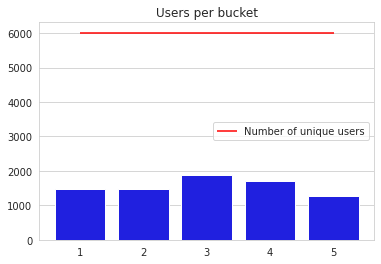

In [22]:
plot_users_per_fixed_bucket(data, 'UserID', interval_start, interval_end)

How many FREQUENT users (occur in 80% or more intervals) exist?

In [23]:
user_bucket_interactions_df, dates_fixed_buckets_df = get_fixed_buckets_info(data, 'UserID', interval_start, interval_end)

In [24]:
frequency_threshold = 0.8

In [25]:
frequent_users_bucket = get_frequent_users_fixed_buckets(user_bucket_interactions_df, frequency_threshold)

83 users of 6014 (1.38%) occur in 80.0% or more buckets.


In median terms, how many times FREQUENT users appear in each bucket?

In [26]:
freq_user_bucket_info = get_frequent_user_statistics(user_bucket_interactions_df, frequent_users_bucket)

<AxesSubplot:>

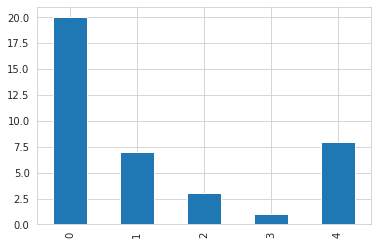

In [27]:
freq_user_bucket_info['median_freq_user_interactions'].plot(kind='bar')

<AxesSubplot:>

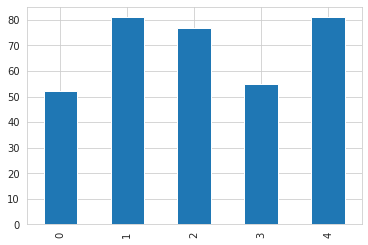

In [28]:
freq_user_bucket_info['freq_users_at_least_1_interaction'].plot(kind='bar')

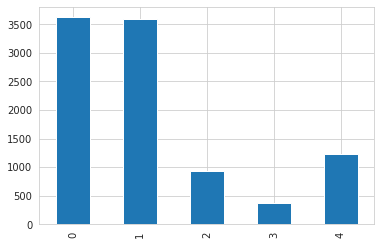

In [29]:
# frequent users interactions per bucket
plot_user_interactions_per_bucket(user_bucket_interactions_df, frequent_users_bucket)

Which timestamps occur in each bucket?

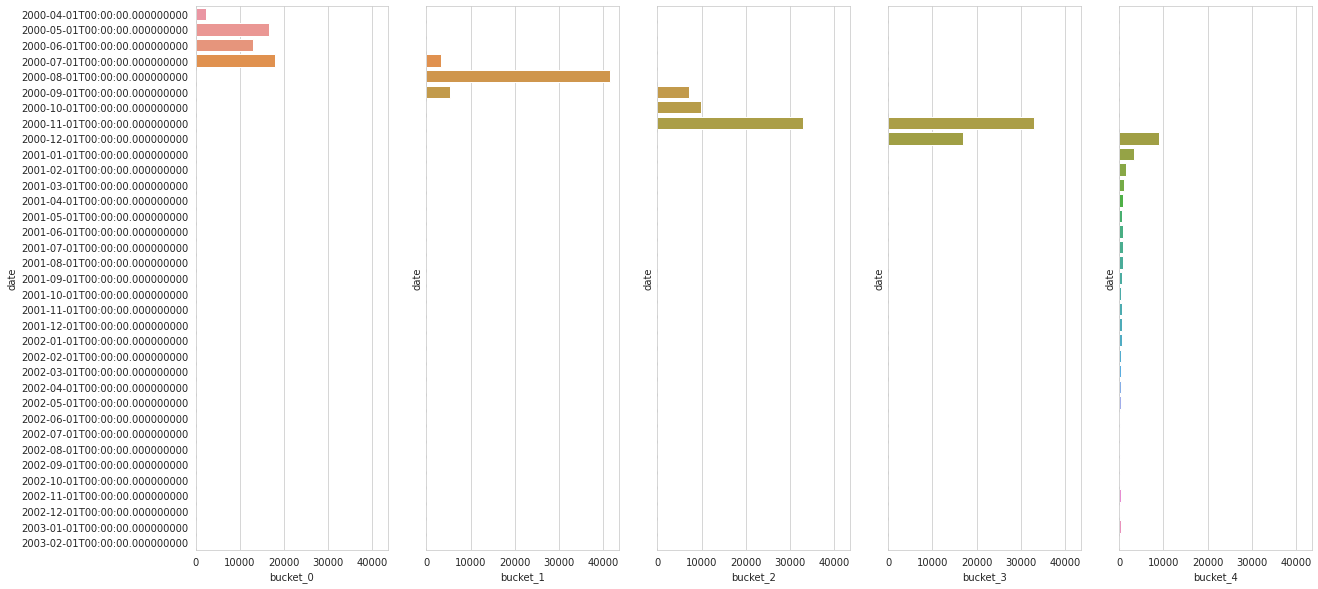

In [30]:
plot_timestamps_per_bucket(dates_fixed_buckets_df)

___
## Store Buckets

In [31]:
num_factors = 160
num_iter = 8
learn_rate = 0.1
regularization = 0.4
num_nodes = 8

In [32]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte.
# recebe listas
# stream = ImplicitData(data['UserID'].to_list(), data['ItemID'].to_list())
stream = ImplicitData(data['UserID'], data['ItemID'])

empty_stream = ImplicitData([], [])

In [33]:
# O modelo não pode conter o stream, deve ser iniciado com uma lista vazia
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [34]:
# criamos instancia de EvaluateAndStore para criar holdouts com o método EvaluateAndStore
n_holdouts = int( data.shape[0]/n_iter_bucket )
eval_movielens = EvaluateAndStore(model=model, data=stream, n_holdouts=n_holdouts, metrics=["Recall@N"], N_recommendations=20, seed=42)

In [35]:
%%time
# interações de 0 a 100 são usadas para pre treino. 
# count define numero de interações a serem usadas.
# holdouts e checkpoints são 
# store_only - somente guarda holdouts, não faz avaliação prequencial.
# default_user - Somente usado quando store_only = False durante avaliação prequencial.
_ = eval_movielens.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True) # 1:40 min

KeyboardInterrupt: 

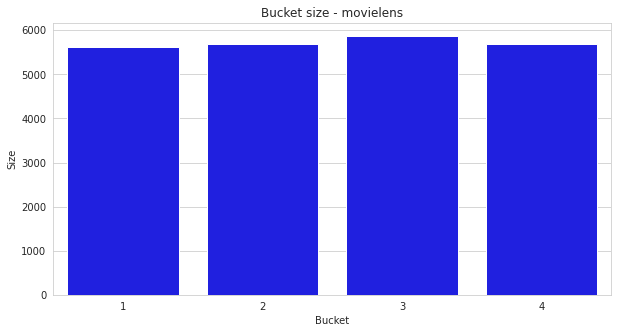

In [ ]:
plot_bucket_size(eval_object=eval_movielens, dataset_name='movielens', filename='movielens_bucket_size.png')

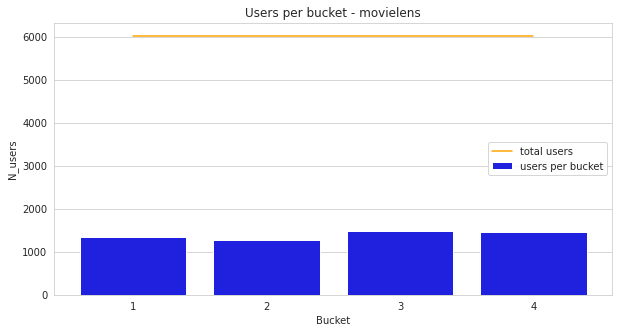

In [ ]:
plot_n_users_per_bucket(eval_object=eval_movielens, dataset_name='movielens', filename='movielens_user_per_bucket.png')

In [ ]:
movielens_ubm = get_bucket_map(eval_object=eval_movielens)
movielens_median_user_presence = median_user_presence_per_bucket(eval_object=eval_movielens, user_bucket_map=movielens_ubm)
print( movielens_median_user_presence )
store_user_presence(dataset_name='movielens', median_user_presence=movielens_median_user_presence)

In [ ]:
joblib.dump(movielens_ubm, 'output/joblib_bucket_info_dump/movielens_ubm', compress=True)

['output/joblib_bucket_info_dump/movielens_ubm']

___